# Install

In [37]:
!pip install git+https://github.com/Farama-Foundation/MAgent2
!git clone https://github.com/kanawanttotimetravel/AIT3007-final-project
%cd AIT3007-final-project

  Cloning https://github.com/Farama-Foundation/MAgent2 to /tmp/pip-req-build-862j7fm3
  Running command git clone --filter=blob:none --quiet https://github.com/Farama-Foundation/MAgent2 /tmp/pip-req-build-862j7fm3
  Resolved https://github.com/Farama-Foundation/MAgent2 to commit b2ddd49445368cf85d4d4e1edcddae2e28aa1406
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
Cloning into 'AIT3007-final-project'...
remote: Enumerating objects: 48, done.
remote: Counting objects: 100% (48/48), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 48 (delta 23), reused 38 (delta 13), pack-reused 0 (from 0)
Receiving objects: 100% (48/48), 13.68 MiB | 36.02 MiB/s, done.
Resolving deltas: 100% (23/23), done.
/kaggle/working/AIT3007-final-project/AIT3007-final-project


# Setup

In [38]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import numpy as np
import random
import matplotlib.pyplot as plt
import magent2
import os
import gymnasium as gym

from magent2.environments import battle_v4

from tqdm.notebook import tqdm

In [39]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Network definition

In [40]:
class FinalQNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            # nn.LayerNorm(120),
            nn.ReLU(),
            nn.Linear(120, 84),
            # nn.LayerNorm(84),
            nn.Tanh(),
        )
        self.last_layer = nn.Linear(84, action_shape)

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        x = self.network(x)
        self.last_latent = x
        return self.last_layer(x)

In [41]:
import torch.nn as nn
import torch


class QNetwork(nn.Module):
    def __init__(self, observation_shape, action_shape):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
            nn.Conv2d(observation_shape[-1], observation_shape[-1], 3),
            nn.ReLU(),
        )
        dummy_input = torch.randn(observation_shape).permute(2, 0, 1)
        dummy_output = self.cnn(dummy_input)
        flatten_dim = dummy_output.view(-1).shape[0]
        self.network = nn.Sequential(
            nn.Linear(flatten_dim, 120),
            nn.ReLU(),
            nn.Linear(120, 84),
            nn.ReLU(),
            nn.Linear(84, action_shape),
        )

    def forward(self, x):
        assert len(x.shape) >= 3, "only support magent input observation"
        x = self.cnn(x)
        if len(x.shape) == 3:
            batchsize = 1
        else:
            batchsize = x.shape[0]
        x = x.reshape(batchsize, -1)
        return self.network(x)


In [42]:
class Config:
    def __init__(
        self,
        step_reward=-0.005,
        dead_penalty=-0.1,
        attack_penalty=-0.1,
        attack_opponent_reward=0.2
    ):
        self.step_reward = step_reward
        self.dead_penalty = dead_penalty
        self.attack_penalty = attack_penalty
        self.attack_opponent_reward = attack_opponent_reward

# Environment setup

In [43]:
conf = Config(
    step_reward=0.001,
    dead_penalty=-0.1,
    attack_penalty=-0.05,
    attack_opponent_reward=0.5
)


env = battle_v4.env(
    map_size=45,
    step_reward=conf.step_reward,
    dead_penalty=conf.dead_penalty,
    attack_penalty=conf.attack_penalty,
    attack_opponent_reward=conf.attack_opponent_reward,
    max_cycles=300,
    render_mode="rgb_array"
)

env.reset()

In [44]:
import cv2
import os
def record_game_video(frames, vid_dir="videos", video_name="random2", fps=5):
    height, width, _ = frames[0].shape
    out = cv2.VideoWriter(
        os.path.join(vid_dir, video_name),
        cv2.VideoWriter_fourcc(*"mp4v"),
        fps,
        (width, height),
    )
    for frame in frames:
        # Convert BGR to RGB since OpenCV uses BGR by default
        frame_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
        out.write(frame_bgr)
    out.release()

In [45]:
observation_shape = env.observation_space("red_0").shape
action_shape = env.action_space("red_0").n
red_weight_path = "red.pt"
blue_weight_path = None

In [46]:
def load_model(model_type, observation_shape, action_shape, path=None):
    model = model_type(observation_shape, action_shape)
    if path is not None:
        model.load_state_dict(torch.load(path, map_location='cpu'))
    model.to(device)
    return model

In [47]:
q_network = load_model(FinalQNetwork, observation_shape, action_shape)

target_q_network = load_model(FinalQNetwork, observation_shape, action_shape)
target_q_network.load_state_dict(q_network.state_dict())

opponent_agent = load_model(FinalQNetwork, observation_shape, action_shape)

# Replay buffer

In [48]:
from collections import defaultdict, deque
class RelayBuffer():
    """
    Store data of blue agent
    data include: observation, action, next_observation, reward, done
    """
    def __init__(self, observation_shape, action_shape, capacity=100000):
        self.storage = []
        self.capacity = capacity
        self.observation_shape = observation_shape
        self.action_shape = action_shape
        self.data = deque(maxlen=capacity)

    def add(self, data_samples):
        self.data.append(data_samples)

    def sample(self, batch_size):
        return random.sample(self.data, batch_size)

    def __len__(self):
        return len(self.data)

    def reset(self):
        self.data.clear()

    def get_all_data(self):
        return self.data

In [49]:
relay_buffer = RelayBuffer(observation_shape, action_shape, capacity= 100000)

In [50]:
frames = []
env.reset()
prev_data = defaultdict(list)  #obs, action
for agent in env.agent_iter():
    observation, reward, termination, truncation, info = env.last()
    agent_team = agent.split('_')[0]
    done = False
    # check if agent died and get action
    if termination or truncation:
        action = None  # this agent has died
        done = True
    else:
        action = env.action_space(agent).sample()

    #if exist prev data, add to relay buffer
    try:
        if agent in prev_data:
            relay_buffer.add((prev_data[agent][0], prev_data[agent][1], observation, reward, done))
    except Exception as e:
        print(prev_data[agent])
        print(e)
        break

    # if agent died, reset prev data
    if termination or truncation:
        prev_data[agent] = None
    else:
        prev_data[agent] = [observation, action]

    # step game
    env.step(action)

    # record frame
    if agent == "red_0":
        frames.append(env.render())
print(len(frames))

301


In [51]:
record_game_video(frames, vid_dir="video", video_name="test_15_12.mp4")

# Hyperparameters

In [52]:
gamma = 0.99
batch_size = 1024
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optimizer = optim.Adam(q_network.parameters(), lr=0.001)
criterion = nn.MSELoss()
epsilon = 1 # epsilon greedy policy
epsilon_decay = 0.99
epsilon_min = 0.1
tau = 0.95 # soft update
max_episodes = 200

# Q-function

In [53]:
def get_q_value(agent: nn.Module, observation: torch.Tensor, batch_size: int= 1024, device: torch.device= device):
    if len(observation.shape) == 3: # single observation
        if isinstance(observation, np.ndarray):
            observation = torch.tensor(observation, dtype=torch.float32, device=device).permute(2, 0, 1)
        else:
            observation = observation.clone().detach().requires_grad_(False).permute(2, 0, 1)
        q_values = agent(observation)
    else: # batch observation
        if isinstance(observation, np.ndarray):
            observation = torch.tensor(observation, dtype=torch.float32, device=device).permute(0, 3, 1, 2)
        else:
            observation = observation.clone().detach().requires_grad_(False).permute(0, 3, 1, 2)
        num_batches = (observation.shape[0] + batch_size - 1) // batch_size
        q_values = []
        for i in range(num_batches):
            start_idx = i * batch_size
            end_idx = min((i + 1) * batch_size, observation.shape[0])
            batch_observation = observation[start_idx:end_idx]
            batch_observation = batch_observation.to(device)
            batch_q_values = agent(batch_observation)
            q_values.append(batch_q_values)
        # print("batch_q_values", batch_q_values.shape)

        q_values = torch.cat(q_values)
    return q_values

In [54]:
def predict_action(agent: nn.Module, observation: torch.Tensor, batch_size: int= 1024):
    with torch.no_grad():
        agent.eval()
        q_values = get_q_value(agent, observation, batch_size)
        return q_values.argmax(dim=1).item()

# Train

In [55]:
def train(agent: nn.Module, target_agent: nn.Module, data: list):
    agent.train()
    # #copy data
    # data = data.copy()
    #shuffle data
    random.shuffle(data)

    #convert to np
    state, action, next_state, reward, done = zip(*data)
    state = np.array(state)
    action = np.array(action)
    next_state = np.array(next_state)
    reward = np.array(reward)
    done = np.array(done)

    #convert to torch tensor
    state = torch.tensor(state, dtype=torch.float32, device=device)
    action = torch.tensor(action, dtype=torch.long, device=device)
    next_state = torch.tensor(next_state, dtype=torch.float32, device=device)
    reward = torch.tensor(reward, dtype=torch.float32, device=device)
    done = torch.tensor(done, dtype=torch.float32, device=device)

    # calculate old_value, Process in smaller batches to avoid OOM
    old_q_values = get_q_value(agent, state, batch_size)

    # calculate target q value
    next_q_values = get_q_value(target_agent, next_state, batch_size)

    # predict value and target value
    try:
        predict = old_q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    except Exception as e:
        print(old_q_values.shape)
        print(old_q_values)
        print(action.shape)
        print(e)
        raise e
    next_max_q_value = next_q_values.max(dim=1).values
    target = reward + gamma * next_max_q_value * (1 - done)

    # calculate loss
    loss = criterion(predict, target)

    # backprop
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss


In [56]:
def get_agent_action(agent_id: str, agent: nn.Module, observation: torch.Tensor, epsilon: float, env: gym.Env):
    if np.random.rand() < epsilon:
        action = env.action_space(agent_id).sample()
    else:
        action = predict_action(agent=agent, observation=observation)
    return action


In [57]:
opponent_q_network = load_model(FinalQNetwork, observation_shape, action_shape)

opponent_q_network.load_state_dict(q_network.state_dict())


<All keys matched successfully>

In [58]:
def initialize_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        nn.init.xavier_normal_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)

q_network.apply(initialize_weights)
target_q_network.load_state_dict(q_network.state_dict())
opponent_q_network.load_state_dict(q_network.state_dict())

<All keys matched successfully>

In [59]:
max_episodes = 100
epsilon = 1

pbar = tqdm(range(max_episodes), position=0, leave=True, desc="Training")
relay_buffer.reset()

red_rewards = []
blue_rewards = []

losses = []

for episode in pbar:

    # epsilon decay
    epsilon = max(epsilon * epsilon_decay, epsilon_min)

    # reset env
    env.reset()

    rewards = [0, 0] # red reward, blue reward
    cycle_count = 0
    last_agent_team = None

    #store data of prev cycle
    prev_data = defaultdict(list)  #obs, action of blue agent
    for agent_id in env.agent_iter():

        observation, reward, termination, truncation, info = env.last()
        agent_team = agent_id.split('_')[0]

        if agent_team == "blue":
            #get action
            if termination or truncation:
                action = None # this agent has died
                done = True
            else:
                action = get_agent_action(agent_id ,q_network, observation, epsilon, env)

            # add data to relay buffer
            try:
                if agent_id in prev_data:
                    relay_buffer.add((prev_data[agent_id][0], prev_data[agent_id][1], observation, reward, done))
            except Exception as e:
                print(prev_data[agent_id])
                print(e)
                break

            # update prev data
            if termination or truncation:
                del prev_data[agent_id]   #delete agent from prev data
            else:
                prev_data[agent_id] = [observation, action]

        else: #red agent_id (random)
            if termination or truncation:
                action = None # this agent_id has died
            else:
                action = get_agent_action(agent_id , opponent_q_network, observation, epsilon, env)

        env.step(action)
        rewards[0] += reward if agent_team == "red" else 0
        rewards[1] += reward if agent_team == "blue" else 0

        if agent_team != last_agent_team and agent_team == "red":
            # frames.append(env.render())
            cycle_count += 1
        last_agent_team = agent_team

    red_rewards.append(rewards[0])
    blue_rewards.append(rewards[1])

    #training
    data = relay_buffer.get_all_data()
    loss = train(q_network, target_q_network, data)
    losses.append(loss)

    # soft update target network
    for param, target_param in zip(q_network.parameters(), target_q_network.parameters()):
        target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)


    pbar.set_description(f"Episode {episode}")
    if (episode + 1) % 10 == 0:
        print(f"Episode {episode} done, step length: {cycle_count}, red reward: {rewards[0]}, blue reward: {rewards[1]}, epsilon: {epsilon:.3f}")
    if (episode + 1) % 25 == 0:
        opponent_q_network.load_state_dict(q_network.state_dict())



Training:   0%|          | 0/100 [00:00<?, ?it/s]

Episode 9 done, step length: 301, red reward: -334.89401969022583, blue reward: -314.3500190231716, epsilon: 0.904
Episode 19 done, step length: 301, red reward: -248.10001867683604, blue reward: -223.28401578427292, epsilon: 0.818
Episode 29 done, step length: 301, red reward: -268.40001535066403, blue reward: -241.75001531501766, epsilon: 0.740
Episode 39 done, step length: 301, red reward: -190.0720131652197, blue reward: -118.9500142185716, epsilon: 0.669
Episode 49 done, step length: 301, red reward: -194.96301183803007, blue reward: -229.10002284660004, epsilon: 0.605
Episode 59 done, step length: 301, red reward: -492.6450257647084, blue reward: -234.424014223041, epsilon: 0.547
Episode 69 done, step length: 301, red reward: -322.54202386701945, blue reward: 12.30997150123585, epsilon: 0.495
Episode 79 done, step length: 301, red reward: -110.26802233257331, blue reward: 246.1179735242622, epsilon: 0.448
Episode 89 done, step length: 301, red reward: -340.6620253100991, blue rew

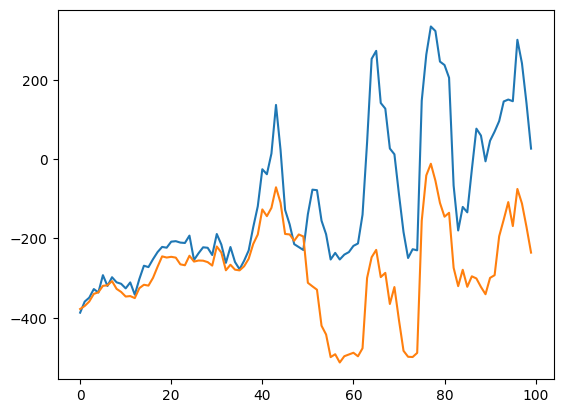

In [60]:
import matplotlib.pyplot as plt

plt.plot(blue_rewards, label='blue_rewards')
plt.plot(red_rewards, label='red_rewards')

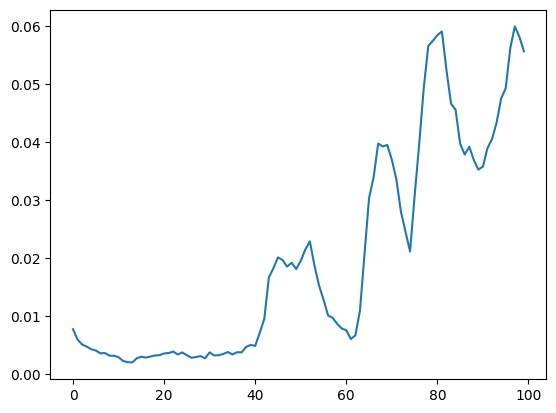

In [61]:
new_losses = []
for loss in losses:
    loss = loss.cpu().data.numpy()
    new_losses.append(loss)

plt.plot(new_losses)
# losses

In [62]:
def plot_rewards_and_losses(episode_rewards, episode_losses):
        # Create a plot with two y-axes for reward and loss
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # Plot rewards
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('Total Reward', color='tab:blue')
        ax1.plot(range(1, len(episode_rewards) + 1), episode_rewards, color='tab:blue', label='Reward')
        ax1.tick_params(axis='y', labelcolor='tab:blue')

        # Create a second y-axis for the loss
        ax2 = ax1.twinx()  
        ax2.set_ylabel('Loss', color='tab:red')
        ax2.plot(range(1, len(episode_losses) + 1), episode_losses, color='tab:red', label='Loss')
        ax2.tick_params(axis='y', labelcolor='tab:red')

        # Title and grid
        plt.title('Reward and Loss per Episode')
        plt.grid(True)
        plt.show()

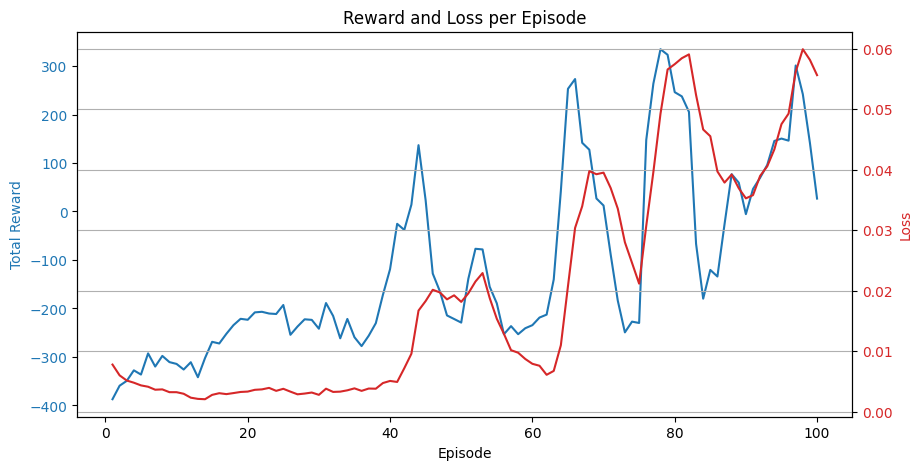

In [63]:
plot_rewards_and_losses(blue_rewards, new_losses)

In [64]:
from datetime import datetime
date = datetime.now().strftime("%Y%m%d%H%M%S")

In [65]:
weight_path = f"q_network_{date}.pt"
torch.save(q_network.state_dict(), weight_path)